In [104]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        # self.initial_scale = tf.keras.layers.Lambda(
        #     lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.initial_scale = tf.keras.layers.Dense(layer_width)
        
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) + Z
        return self.out(Z)




In [122]:
# Aiyagari problem parameters
kappa = 0.5  # mean reversion rate
theta = 0.0  # mean reversion level
sigma = 2    # volatility

# mean and standard deviation for (normally distributed) process starting value
alpha = 0.0
beta = 1

T = 1.0

nSim_t = 5
nSim_x_interior = 100
nSim_x_initial = 100

X_low = np.array([0,-4])  # wealth lower bound
X_high = np.array([T,4])          # wealth upper bound


# neural network parameters
num_layers_FFNN = 6
num_layers_RNN = 0
nodes_per_layer = 50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'
# Training parameters
sampling_stages  = 2000   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling


dim_input = 2
dim_output = 1
 
model = DCGMNet(X_low, X_high,  
                 dim_input, dim_output, 
                 num_layers_FFNN, nodes_per_layer,
                 activation_FFNN)





In [123]:
def simulateOU_GaussianStart(alpha, beta, theta, kappa, sigma, nSim, T):
    ''' Simulate end point of Ornstein-Uhlenbeck process with normally 
        distributed random starting value.
    
    Args:
        alpha: mean of random starting value
        beta:  standard deviation of random starting value
        theta: mean reversion level
        kappa: mean reversion rate
        sigma: volatility 
        nSim:  number of simulations
        T:     terminal time        
    '''  
        
    # simulate initial point based on normal distribution
    X0 = np.random.normal(loc = alpha, scale = beta, size = nSim)
    
    # mean and variance of OU endpoint
    m = theta + (X0 - theta) * np.exp(-kappa * T)
    v = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2*kappa*T)))
    
    # simulate endpoint
    Xt = np.random.normal(m,v)    
    
    return Xt



def sampler(nSim_t, nSim_x_interior, nSim_x_initial):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_t:          number of (interior) time points to sample
        nSim_x_interior: number of space points in the interior of the function's domain to sample 
        nSim_x_initial:  number of space points at initial time to sample (initial condition)
    ''' 
    
    # Sampler #1: domain interior
    t = np.random.uniform(low=0, high=T, size=[nSim_t, 1])
    x_interior = np.random.uniform(low=X_low[1], high=X_high[1], size=[nSim_x_interior, 1])
    
    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem 
    
    # Sampler #3: initial/terminal condition
    x_initial = np.random.uniform(low=X_low[1], high=X_high[1], size = [nSim_x_initial, 1])
    
    return t, x_interior, x_initial



def compute_loss(model, t, x_interior, x_initial, nSim_t):
    ''' Compute total loss for training.
        NOTE: the loss is based on the PDE satisfied by the negative-exponential
              of the density and NOT the density itself, i.e. the u(t,x) in 
              p(t,x) = exp(-u(t,x)) / c(t)
              where p is the density and c is the normalization constant
    
    Args:
        model:      DGM model object
        t:          sampled (interior) time points
        x_interior: sampled space points in the interior of the function's domain
        x_initial:  sampled space points at initial time
        nSim_t:     number of (interior) time points sampled (size of t)
        alpha:      mean of normal distribution for process starting value
        beta:       standard deviation of normal distribution for process starting value
    ''' 
    
    # Loss term #1: PDE
    
    # initialize vector of losses
    losses_u = []
    
    # for each simulated interior time point
    for tIndex in range(nSim_t):
        
        # make vector of current time point to align with simulated interior space points   
        curr_t = tf.cast(t[tIndex],tf.float32)
        x_interior = tf.cast(tf.reshape(x_interior, shape=[
                             nSim_x_interior, 1]), tf.float32)
        t_vector = curr_t * tf.ones_like(x_interior)
        # print(t_vector)
        # compute function value and derivatives at current sampled points
        u    = model(tf.stack([t_vector[:,0], x_interior[:,0]], axis=1))
        u_t = tf.gradients(u, t_vector)[0]
        u_x = tf.gradients(u, x_interior)[0]
        u_xx = tf.gradients(u_x, x_interior)[0]

        # psi function: normalized and exponentiated neural network
        # note: sums are used to approximate integrals (importance sampling)
        psi_denominator = tf.reduce_sum(tf.exp(-u))
        # print(u_t)
        psi = tf.reduce_sum( u_t*tf.exp(-u) ) / psi_denominator

        # PDE differential operator
        # NOTE: EQUATION IN DOCUMENT IS INCORRECT - EQUATION HERE IS CORRECT
        diff_f = -u_t - kappa + kappa*(x_interior- theta)*u_x - 0.5*sigma**2*(-u_xx + u_x**2) + psi
        
        # compute L2-norm of differential operator and attach to vector of losses
        currLoss = tf.reduce_mean(tf.square(diff_f)) 
        losses_u.append(currLoss)
    
    # average losses across sample time points 
    L1 = tf.add_n(losses_u) / nSim_t
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    
    # Loss term #3: initial condition
    
    # compute negative-exponential of neural network-implied pdf at t = 0
    # i.e. the u in p = e^[-u(t,x)] / c(t)
    
    
    # init_t = tf.cast(0, tf.float32)
    # x_interior = tf.cast(tf.reshape(x_interior, shape=[
    #     nSim_x_interior, 1]), tf.float32)
    # t_vector = init_t * tf.ones_like(x_interior)
    
    fitted_pdf = model(
        tf.stack([0*tf.ones_like(x_initial)[:,0], x_initial[:,0]], axis=1))
    # target pdf - normally distributed starting value
    # NOTE: we are only comparing the exponential terms 
    target_pdf = tf.cast(0.5*(x_initial - alpha)**2 / (beta**2),tf.float32)
    
    # average L2 error for initial distribution
    L3 = tf.reduce_mean(tf.square(fitted_pdf - target_pdf))


    return L1, L3    


In [124]:

    
def get_grad(model, t, x_interior, x_initial, nSim_t):
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model.trainable_variables)
        loss1, loss3 = compute_loss(model, t, x_interior, x_initial, nSim_t)
        loss = loss1+loss3

    grad = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, grad

In [125]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=starting_learning_rate)


@tf.function
def train_step(model, t, x_interior, x_initial, nSim_t, alpha, beta):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, t, x_interior, x_initial, nSim_t)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    t, x_interior, x_initial = sampler(nSim_t, nSim_x_interior, nSim_x_initial)

    for _ in range(steps_per_sample):
        loss = train_step(model, t, x_interior, x_initial, nSim_t, alpha, beta)
    
    hist.append(loss.numpy())
    
    if i%100==0:
        tf.print(i,loss)
    

0 11.8813028
100 0.012365967
200 0.0053374297
300 0.00161985308
400 0.0137984436
500 0.0015755475
600 0.0422837511
700 0.00129688333
800 0.00544904592
900 0.000753124827
1000 0.00137183222
1100 0.00612269342
1200 0.000812515325
1300 0.0141397687
1400 0.00117711525
1500 0.000992141315
1600 0.018836502
1700 0.00207799347
1800 0.00086896884


KeyboardInterrupt: 

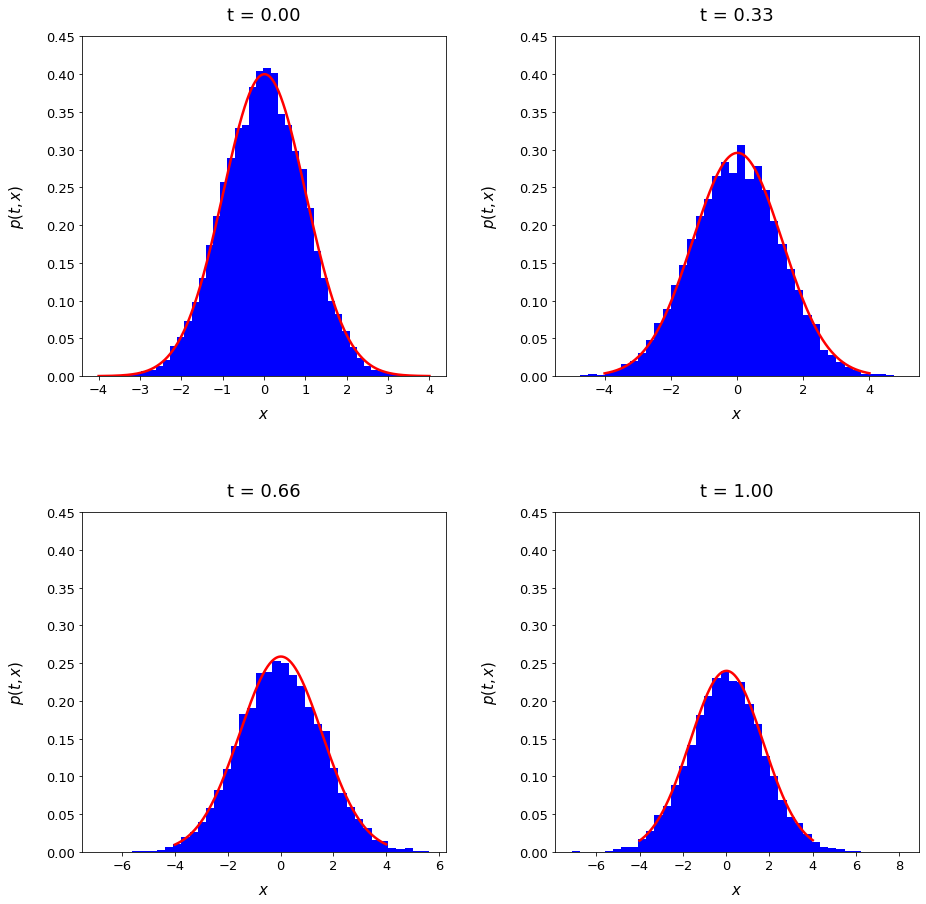

In [140]:

densityTimes = [0, 0.33*T, 0.66*T, T]

# vector of x values for plotting
x_plot = np.linspace(X_low[1], X_high[1], 1000)

plt.subplots(2, 2,figsize=(15, 15))

for i, curr_t in enumerate(densityTimes):

    # specify subplot
    plt.subplot(2, 2, i+1)

    # simulate process at current t
    sim_x = simulateOU_GaussianStart(
        alpha, beta, theta, kappa, sigma, 10000, curr_t)

    curr_t = tf.cast(curr_t,tf.float32)
    # compute normalized density at all x values to plot and current t value
    x_plot = tf.cast(tf.reshape(x_plot, shape=[
        1000, 1]), tf.float32)
    t_plot = curr_t * tf.ones_like(x_plot)

    u = model(tf.stack([t_plot[:, 0], x_plot[:, 0]], axis=1))
    u = u.numpy().reshape(-1,1)
    
    p = np.exp(-u)
    x_plot_orig = np.linspace(X_low[1], X_high[1], 1000)
    # print()

    density = p/np.trapz(p.reshape(x_plot_orig.shape), x_plot_orig)

    # plot histogram of simulated process values and overlay estimated density
    plt.hist(sim_x, bins=40, density=True, color='b')
    plt.plot(x_plot, density, 'r', linewidth=2.5)

    # subplot options
    plt.ylim(ymin=0.0, ymax=0.45)
    plt.xlabel(r"$x$", fontsize=15, labelpad=10)
    plt.ylabel(r"$p(t,x)$", fontsize=15, labelpad=20)
    plt.title(r"t = %.2f" %
              (curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)
